# Rover Response Optimization

This notebook shows how variables in an fmdtools model can be optimized for resilience.

In [1]:
from fmdtools.sim.sample import SampleApproach, FaultSample, FaultDomain, ParameterDomain
import fmdtools.analyze as an
import fmdtools.sim.propagate as prop
from fmdtools.sim.search import ParameterSimProblem
import matplotlib.pyplot as plt
import multiprocessing as mp
import time

Model is in defined rover_model.py

In [2]:
from examples.rover.rover_model import Rover, RoverParam

## Optimization

Here we define the optimization problem for the rover.

We use a parallel pool, staged execution, and minimal tracking options to lower computational cost as much as possible.

In [3]:
mdl = Rover(sp={'end_condition': ''})
track={'functions':{"Environment":"in_bound"},'flows':{"Ground":"all"}}
#rover_prob = search.ProblemInterface("rover_problem", mdl, pool=mp.Pool(5), staged=True, track=track)

In [4]:
mdl.p

RoverParam(ground=GroundParam(linetype='sine', amp=1.0, period=6.283185307179586, radius=20.0, x_start=10.0, y_end=10.0, x_min=0.0, x_max=30.0, x_res=0.1, path_buffer_on=0.2, path_buffer_poor=0.3, path_buffer_near=0.4, dest_buffer_on=1.0, dest_buffer_near=2.0), correction=ResCorrection(ub_f=10.0, lb_f=-1.0, ub_t=10.0, lb_t=0.0, ub_d=2.0, lb_d=-2.0, cor_d=0.0, cor_t=0.0, cor_f=0.0), degradation=DegParam(friction=0.0, drift=0.0), drive_modes={'mode_args': 'set'})

Here we will be optimizing over faults in the drive system at 3 points during the drive simulation interval:

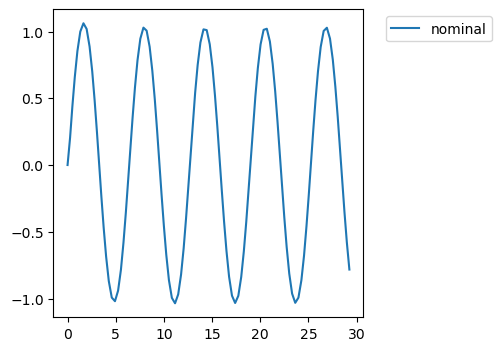

In [5]:
endresults, mdlhist = prop.nominal(mdl)
phasemap = an.phases.from_hist(mdlhist)
fault_domain = FaultDomain(mdl)
fault_domain.add_all_fxnclass_modes('Drive')
fault_sample = FaultSample(fault_domain, phasemap['plan_path'])
fault_sample.add_fault_phases('drive',  args=(3,))
fig, ax = mdlhist.plot_trajectories("flows.pos.s.x", "flows.pos.s.y")

The variables are the correction factors int the fault management: 

In [6]:
pd = ParameterDomain(RoverParam)
pd.add_variables("correction.cor_f", "correction.cor_d", "correction.cor_t", lims={"correction.cor_f":(0, 1), 
                                                                                         "correction.cor_d":(-1, 1),
                                                                                         "correction.cor_t":(-1, 1)})
pd

ParameterDomain with:
 - variables: {'correction.cor_f': (0, 1), 'correction.cor_d': (-1, 1), 'correction.cor_t': (-1, 1)}
 - constants: {}
 - parameter_initializer: RoverParam

Now we setup the optimization problem using `ParameterSimProblem`

In [7]:
rover_prob = ParameterSimProblem(mdl, pd, 'fault_sample', fault_sample)
rover_prob

ParameterSimProblem with:
VARIABLES
 -correction.cor_f                                              nan
 -correction.cor_d                                              nan
 -correction.cor_t                                              nan

We can define multiple objectives, below we will use the end distanceand total_deviation from find_classification. 

In [8]:
rover_prob.add_result_objective('f1', 'endclass.end_dist')
rover_prob.add_result_objective('f2', 'endclass.tot_deviation')
rover_prob

ParameterSimProblem with:
VARIABLES
 -correction.cor_f                                              nan
 -correction.cor_d                                              nan
 -correction.cor_t                                              nan
OBJECTIVES
 -f1                                                            nan
 -f2                                                            nan

Here we do some basic timing:

In [9]:
rover_prob.f1(0.5,0.5,0.5)
a=time.time()
rover_prob.f1(0.6,0.5,0.5)
t=time.time()-a
t

14.286731719970703

In [10]:
rover_prob

ParameterSimProblem with:
VARIABLES
 -correction.cor_f                                           0.6000
 -correction.cor_d                                           0.5000
 -correction.cor_t                                           0.5000
OBJECTIVES
 -f1                                                      1213.9601
 -f2                                                        18.0247

Alternatively, we can use:

In [11]:
rover_prob.time_execution(0.7,0.5,0.5)

14.212275266647339

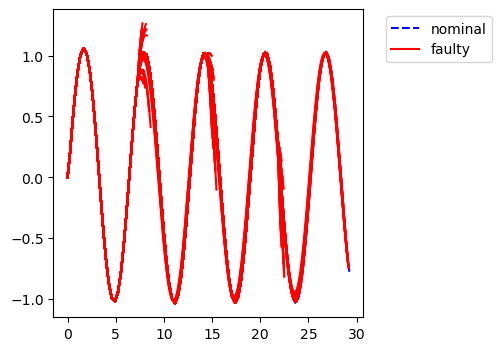

In [12]:
fig, ax = rover_prob.hist.plot_trajectories("flows.pos.s.x", "flows.pos.s.y")

In [13]:
rover_prob

ParameterSimProblem with:
VARIABLES
 -correction.cor_f                                           0.7000
 -correction.cor_d                                           0.5000
 -correction.cor_t                                           0.5000
OBJECTIVES
 -f1                                                      1218.9110
 -f2                                                        17.9397

### Rover Optimization: 

In [14]:
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.problems.functional import FunctionalProblem
import numpy as np

Covert optimization problem into a pymoo problem

In [15]:
n_var = len(rover_prob.variables)
x_low = np.array([])
x_up = np.array([])
for bound in rover_prob.parameterdomain.variables.values():
    x_low = np.append(x_low, bound[0])
    x_up = np.append(x_up, bound[1])
    
obj = [lambda x: rover_prob.f1(*x)]
pymoo_prob = FunctionalProblem(n_var, obj, xl = x_low, xu= x_up)

In [16]:
arg={}
pymoo_prob._evaluate([0.7,0.5,0.5],arg)

In [17]:
arg

{'F': array([1218.91096448]),
 'G': array([], dtype=float64),
 'H': array([], dtype=float64)}

Run optimizaion algorithm..

In [18]:
algorithm=PatternSearch(x0=np.array([0.7,0.5,0.5])) 

In [19]:
res = minimize(pymoo_prob, algorithm, verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        1 |  1.218911E+03 |  1.218911E+03
     2 |        6 |  1.213298E+03 |  1.207685E+03
     3 |       12 |  1.190913E+03 |  1.174142E+03
     4 |       18 |  1.059292E+03 |  9.444427E+02
     5 |       24 |  9.421836E+02 |  9.399245E+02
     6 |       31 |  9.387046E+02 |  9.374847E+02
     7 |       38 |  9.382169E+02 |  9.374847E+02
     8 |       44 |  9.374847E+02 |  9.374847E+02
     9 |       49 |  9.371749E+02 |  9.368652E+02
    10 |       56 |  9.368652E+02 |  9.368652E+02
    11 |       61 |  9.366039E+02 |  9.363427E+02
    12 |       67 |  9.355650E+02 |  9.347873E+02
    13 |       74 |  9.349069E+02 |  9.347873E+02
    14 |       80 |  9.347504E+02 |  9.347134E+02
    15 |       87 |  9.347134E+02 |  9.347134E+02
    16 |       92 |  9.346589E+02 |  9.346045E+02
    17 |       98 |  9.351353E+02 |  9.346045E+02
    18 |      104 |  9.346045E+02 |  9.346045E+02
    19 |      107 |  9.345889E+02 |  9.345733E+02


In [20]:
res.X

array([ 0.16970361, -0.78522209,  0.10777078])

### Results visualization

Here we look at the optimized results and compare with the starting results:

In [21]:
rover_prob.f1(0.16970361, -0.78522209,  0.10777078)

934.5036574329059

ParameterSimProblem with:
VARIABLES
 -correction.cor_f                                           0.1697
 -correction.cor_d                                          -0.7852
 -correction.cor_t                                           0.1078
OBJECTIVES
 -f1                                                       934.5037
 -f2                                                        16.9844

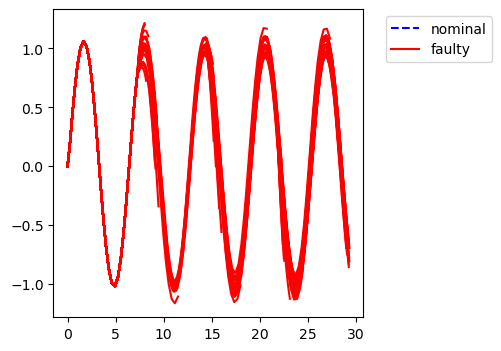

In [23]:
fig, ax = rover_prob.hist.plot_trajectories("flows.pos.s.x", "flows.pos.s.y")
rover_prob

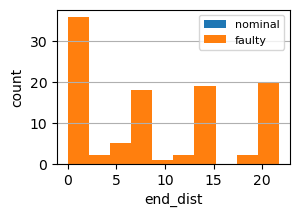

In [24]:
fig, ax = rover_prob.res.plot_metric_dist('end_dist')

starting solution:

In [25]:
rover_prob.f1(0.7,0.5,0.5)

1218.9109644843713

ParameterSimProblem with:
VARIABLES
 -correction.cor_f                                           0.7000
 -correction.cor_d                                           0.5000
 -correction.cor_t                                           0.5000
OBJECTIVES
 -f1                                                      1218.9110
 -f2                                                        17.9397

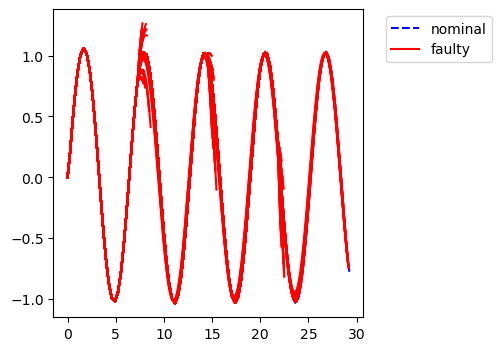

In [26]:
fig, ax = rover_prob.hist.plot_trajectories("flows.pos.s.x", "flows.pos.s.y")
rover_prob

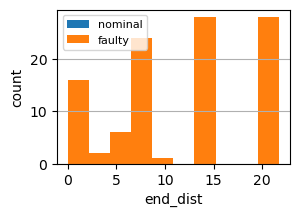

In [27]:
fig, ax = rover_prob.res.plot_metric_dist('end_dist')

As shown, while the optimized correction factors don't mitigate all scenarios, they do increase the number of scenarios that are mitigated.